In [11]:
import os
import numpy as np
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
from utils import utils_3d

eval_logdir = './eval_log'
dataset_dir = 'deeplab/datasets/apolloscape/combined/'
mat_list = os.listdir(eval_logdir+'/mat_res')
print len(mat_list)

def plot_map(map, title='', vmin=None, vmax=None, cmap=None):
    plt.figure(figsize=(15, 5))
    plt.title(title)
    plt.imshow(map, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar()
    plt.show()

split = 'train'
# dataset_dir = '%s/%s/pose_maps_02/'(dataset_dir, split)

# for idx in range(1):
idx = 1
files = [file_name for file_name in mat_list if file_name.startswith('%d-%s-'%(idx, split))]
assert len(files) == 1
mat_name = files[0]
results = loadmat(eval_logdir+'/mat_res/'+mat_name)

print results.keys()

5091
['shape_id_sim_map', '__globals__', 'image', 'mask', 'image_name', 'rot_error_map', '__header__', 'seg', 'vis', 'shape_id_map', 'trans_error_map', 'logits_pose_shape_map', 'label_pose_shape_map', '__version__', 'shape_id_map_predict']


# Plot metrics

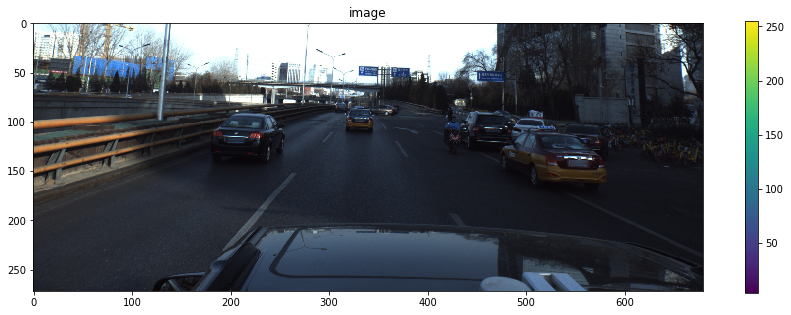

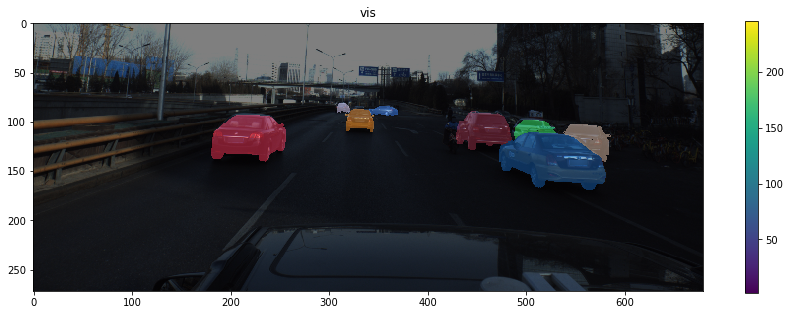

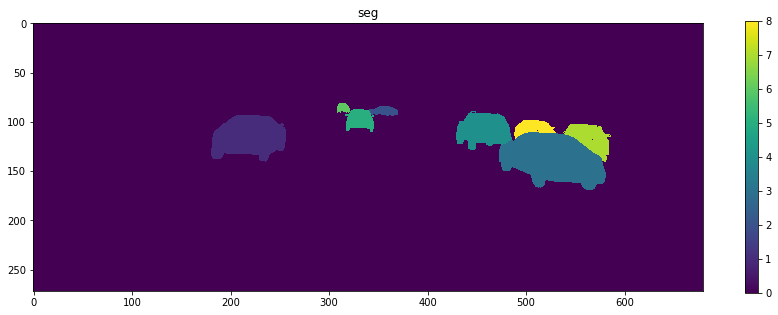

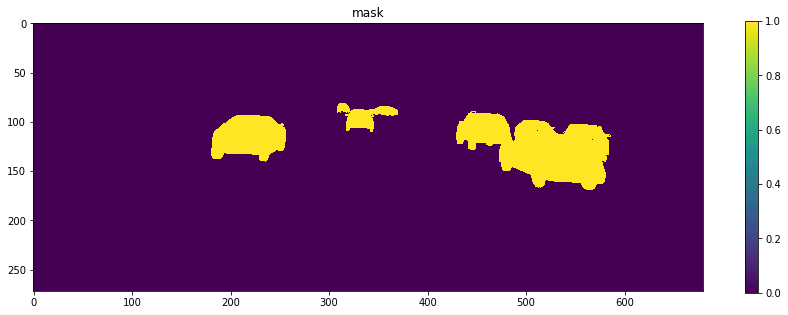

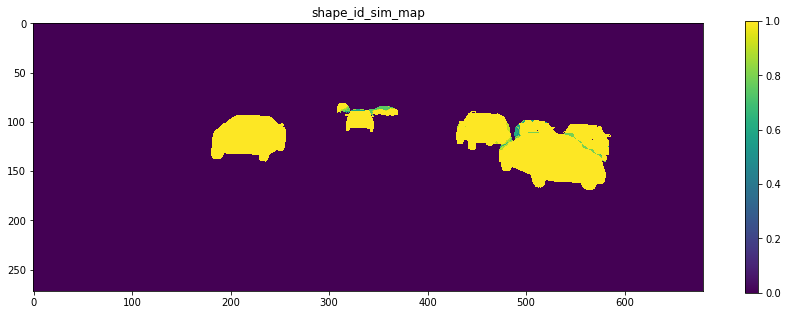

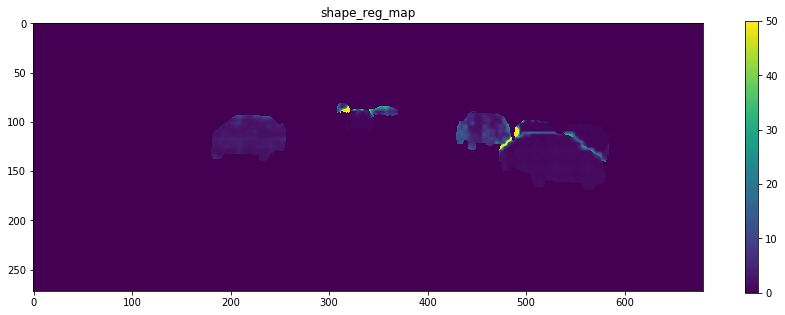

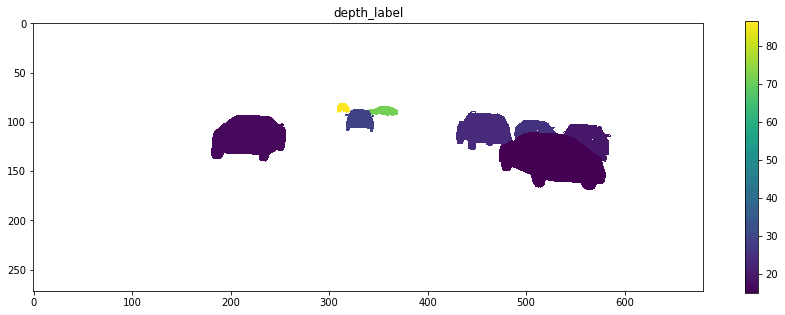

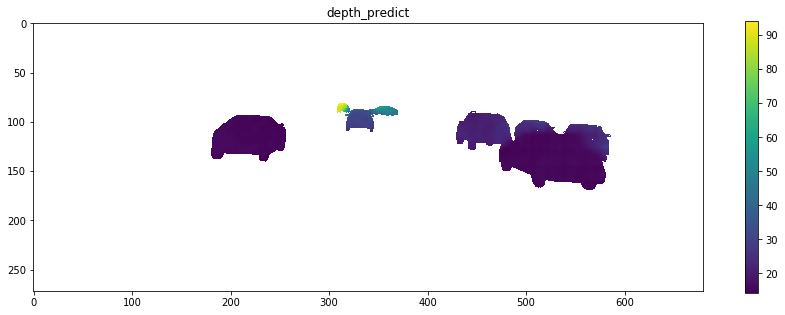

/home/vis/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in subtract


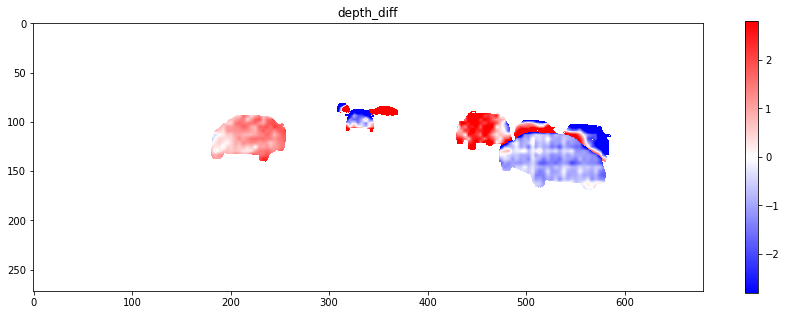

In [18]:
image = np.squeeze(results['image'])
plot_map(image, 'image')

vis = np.squeeze(results['vis'])
plot_map(vis, 'vis')

seg = np.squeeze(results['seg'])
plot_map(seg, 'seg')

mask = np.squeeze(results['mask'])
plot_map(mask, 'mask')

shape_id_sim_map = np.squeeze(results['shape_id_sim_map'])
plot_map(shape_id_sim_map, 'shape_id_sim_map')

shape_reg_map = np.squeeze(results['logits_pose_shape_map'])[:, :, 7:] - np.squeeze(results['label_pose_shape_map'])[:, :, 7:]
shape_reg_map = np.sqrt(np.sum(np.square(shape_reg_map), axis=2))
shape_reg_map[mask==0]=0.
plot_map(shape_reg_map, 'shape_reg_map', vmin=0, vmax=50)

label_pose_shape_map = np.copy(np.squeeze(results['label_pose_shape_map']))
label_depth_map = label_pose_shape_map[:, :, 6]
label_depth_map[mask==0]=np.inf
label_depth_map[mask==1]=(1./label_depth_map)[mask==1]
plot_map(label_depth_map, 'depth_label')

logits_pose_shape_map = np.copy(np.squeeze(results['logits_pose_shape_map']))
# print logits_pose_shape_map.shape
logits_depth_map = logits_pose_shape_map[:, :, 6]
logits_depth_map[mask==0]=np.inf
logits_depth_map[mask==1]=(1./logits_depth_map)[mask==1]
plot_map(logits_depth_map, 'depth_predict')
# , vmin=np.min(label_depth_map[mask==1]), vmax=np.max(label_depth_map[mask==1]))

plot_map((label_depth_map - logits_depth_map), 'depth_diff', cmap='bwr', vmin=-2.8, vmax=2.8)

/home/vis/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.


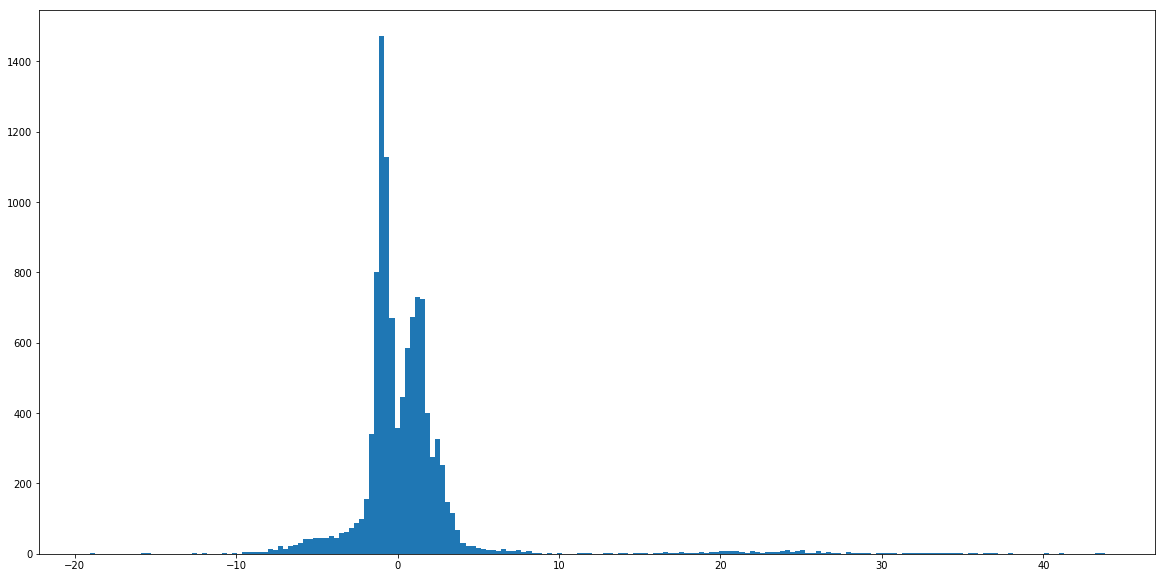

In [19]:
diff = (label_depth_map - logits_depth_map).flatten()
diff = diff[np.logical_not(np.isnan(diff))]
plt.figure(figsize=(20, 10))
plt.hist(diff, bins=200)
plt.show()

# Separete instances

In [20]:
%reload_ext autoreload
%autoreload 2
from utils import utils_3d
num_cars = int(np.max(seg))
# print num_cars
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

codes = np.load('/ssd2/public/zhurui/Documents/mesh-voxelization/models/cars_64/codes.npy')
shape_sim_mat = np.loadtxt('dataset-api/car_instance/sim_mat.txt')

import json
data = []  

for idx in range(num_cars):
    mask_singe = seg==(idx+1)
    mask_singe_float = mask_singe.astype(np.float)
    
#     plot_map(mask_singe_float)

    def _aggregate_pose_map(logits_pose_map_single):
        logits_pose_map_single_quat = logits_pose_map_single[:, :4]
        logits_pose_map_single_quat = logits_pose_map_single_quat / np.linalg.norm(logits_pose_map_single_quat, axis=1, keepdims=True)
        logits_pose_map_single_euler_angles_list = []
        for quat in logits_pose_map_single_quat:
            R = utils_3d.quater_to_rot_mat(quat)
            euler_angles = utils_3d.rotation_matrix_to_euler_angles(R, check=True)
            logits_pose_map_single_euler_angles_list.append(euler_angles)
        logits_pose_map_single_euler = np.stack(logits_pose_map_single_euler_angles_list)

        logits_pose_map_single_convert = np.concatenate((logits_pose_map_single_euler, logits_pose_map_single[:, 4:6], (logits_pose_map_single)[:, 6:7]), axis=1)
        
        logits_pose_map_single_convert_aggre = np.median(logits_pose_map_single_convert, axis=0)
        return logits_pose_map_single_convert_aggre
        
    logits_pose_single_convert_aggre = _aggregate_pose_map(logits_pose_shape_map[:, :, :7][mask_singe])
    label_pose_single_convert_aggre = _aggregate_pose_map(label_pose_shape_map[:, :, :7][mask_singe])
    
    def _aggregate_shape_map(logits_shape_map_single):
        logits_shape_map_single_median = np.median(logits_shape_map_single, axis=0)
        error = np.square(codes - np.repeat(np.expand_dims(logits_shape_map_single_median, -1), 79, axis=1))
        error = np.sum(error, axis=0)
        return np.argmax(error)
    
    logits_shape_single_convert_aggre = _aggregate_shape_map(logits_pose_shape_map[:, :, 7:][mask_singe])
    label_shape_single_convert_aggre = _aggregate_shape_map(label_pose_shape_map[:, :, 7:][mask_singe])
#     print shape_sim_mat[logits_shape_single_convert_aggre, label_shape_single_convert_aggre]
    
    print logits_pose_single_convert_aggre, logits_shape_single_convert_aggre 
    
    data.append({  
        'car_id': logits_shape_single_convert_aggre,
        'pose': logits_pose_single_convert_aggre.tolist(),
    })

image_name = results['image_name'][0][0][0].encode('ascii','ignore').replace('%s-'%split, '')
print data
with open('%s/det3d_res/%s.json'%(eval_logdir, image_name), 'w') as outfile:  
    json.dump(data, outfile, sort_keys=True, indent=4,
                    ensure_ascii=False)

[ 0.1817  0.0145 -3.0758 -4.2941  3.9009 15.7653] 5
[ 0.164   0.0393 -3.0706  0.8284  9.7775 48.7861] 5
[ 0.1864  0.0223 -3.0732  5.3998  4.6574 15.9024] 5
[ 0.1743  0.0433 -3.0758  5.7074  5.1842 21.4463] 17
[ 0.1786  0.0091 -3.0766 -1.1503  6.1792 30.4038] 5
[ 0.1522  0.1692 -3.0251 -6.4272 15.3625 86.3381] 17
[ 0.3399 -0.9437  2.8624  8.6783  5.2978 21.9889] 5
[ 0.252  -0.6886  2.9846  8.1914  5.489  23.3224] 5
[{'pose': [0.1817205468509506, 0.014482901535666207, -3.075790020777415, -4.294050455093384, 3.9008660316467285, 15.765305995941162], 'car_id': 5}, {'pose': [0.16404147536067903, 0.03926712012361435, -3.0706375006744087, 0.828437864780426, 9.7774658203125, 48.786128997802734], 'car_id': 5}, {'pose': [0.1864238379205815, 0.022256811185910077, -3.073176203531489, 5.399839878082275, 4.657365798950195, 15.902414321899414], 'car_id': 5}, {'pose': [0.17426357930384528, 0.04327191314803955, -3.0757787392218034, 5.7073752880096436, 5.184210777282715, 21.446298599243164], 'car_id': 17

# Batch process for all

In [8]:
import os
import numpy as np
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
from utils import utils_3d
import json

dataset_dir = 'deeplab/datasets/apolloscape/combined/'
option = 2
splits = ['train', 'val', 'test']
dataset_size = [4611, 480, 1041]
split = splits[option]

eval_logdir = './eval_log'+'/mat_res/%s'%split
mat_list = os.listdir(eval_logdir)
print len(mat_list)

codes = np.load('/ssd2/public/zhurui/Documents/mesh-voxelization/models/cars_64/codes.npy')
shape_sim_mat = np.loadtxt('dataset-api/car_instance/sim_mat.txt')
pose_maps_root = 'datasets/apolloscape/combined/%s/pose_maps_02'%split

def plot_map(map, title='', vmin=None, vmax=None, cmap=None):
    plt.figure(figsize=(15, 5))
    plt.title(title)
    plt.imshow(map, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar()
    plt.show()

def _aggregate_pose_map(logits_pose_map_single):
    logits_pose_map_single_quat = logits_pose_map_single[:, :4]
    logits_pose_map_single_quat = logits_pose_map_single_quat / np.linalg.norm(logits_pose_map_single_quat, axis=1, keepdims=True)
    logits_pose_map_single_euler_angles_list = []
    for quat in logits_pose_map_single_quat:
        R = utils_3d.quater_to_rot_mat(quat)
        euler_angles = utils_3d.rotation_matrix_to_euler_angles(R, check=True)
        logits_pose_map_single_euler_angles_list.append(euler_angles)
    logits_pose_map_single_euler = np.stack(logits_pose_map_single_euler_angles_list)

    logits_pose_map_single_convert = np.concatenate((logits_pose_map_single_euler, logits_pose_map_single[:, 4:6], 1./(logits_pose_map_single)[:, 6:7]), axis=1)

    logits_pose_map_single_convert_aggre = np.median(logits_pose_map_single_convert, axis=0)
    return logits_pose_map_single_convert_aggre

def _aggregate_shape_map(logits_shape_map_single):
    logits_shape_map_single_median = np.median(logits_shape_map_single, axis=0)
    error = np.square(codes - np.repeat(np.expand_dims(logits_shape_map_single_median, -1), 79, axis=1))
    error = np.sum(error, axis=0)
    return np.argmax(error)

for idx in range(dataset_size[option]): 
    files = [file_name for file_name in mat_list if file_name.startswith('%d-%s-'%(idx, split))]
#     print files
    assert len(files) == 1
    mat_name = files[0]
#     print mat_name
    results = loadmat(eval_logdir+'/'+mat_name)
    
    image_name = mat_name.split('-')[2].replace('.mat', '')
    
    seg = np.squeeze(results['seg'])
    logits_pose_shape_map = np.squeeze(results['logits_pose_shape_map'])
    if split != 'test':
        label_pose_shape_map = np.squeeze(results['label_pose_shape_map'])
    num_cars = int(np.max(seg))
    
    if split == 'test':
        scores_file = pose_maps_root+'/'+image_name+'_segScores.npy'
        scores = np.load(scores_file).tolist()
        assert len(scores) == num_cars, 'Scores and number of cars in json mismatch! %d, %d'%(len(scores), num_cars)
    
    data = []  
    shape_metric_list = []
    trans_metric_list = []
    for car_idx in range(num_cars):
        mask_singe = seg==(car_idx+1)
        mask_singe_float = mask_singe.astype(np.float)
        if np.sum(mask_singe_float) == 0:
            continue
            
        logits_pose_single_convert_aggre = _aggregate_pose_map(logits_pose_shape_map[:, :, :7][mask_singe])
#         print logits_pose_single_convert_aggre
        if split != 'test':
            label_pose_single_convert_aggre = _aggregate_pose_map(label_pose_shape_map[:, :, :7][mask_singe])
            trans_metric = np.sqrt(np.sum(np.square(logits_pose_single_convert_aggre[3:] - label_pose_single_convert_aggre[3:])))
            trans_metric_list.append(trans_metric)

        logits_shape_single_convert_aggre = _aggregate_shape_map(logits_pose_shape_map[:, :, 7:][mask_singe])
        if split != 'test':
            label_shape_single_convert_aggre = _aggregate_shape_map(label_pose_shape_map[:, :, 7:][mask_singe])

        data.append({  
            'car_id': logits_shape_single_convert_aggre,
            'pose': logits_pose_single_convert_aggre.tolist(),
            'score': scores[car_idx] if split == 'test' else 1.
        })
        
        if split != 'test':
            shape_metric = shape_sim_mat[logits_shape_single_convert_aggre, label_shape_single_convert_aggre]
            shape_metric_list.append(shape_metric)

    image_name = results['image_name'][0][0][0].encode('ascii','ignore').replace('%s-'%split, '')
    print 'Writing %d-%s; num_cars: %d; shape metrics: %.2f; trans metrics: %.2f' % \
    (idx, image_name, num_cars, np.mean(shape_metric_list), np.mean(trans_metric_list))
    with open('./eval_log/det3d_res/%s.json'%(image_name), 'w') as outfile:  
        json.dump(data, outfile, sort_keys=True, indent=4,
                        ensure_ascii=False)


1042
Writing 0-171206_080433758_Camera_5; num_cars: 10; shape metrics: nan; trans metrics: nan
Writing 1-180116_053647893_Camera_5; num_cars: 13; shape metrics: nan; trans metrics: nan
Writing 2-180114_025136622_Camera_5; num_cars: 13; shape metrics: nan; trans metrics: nan
Writing 3-180116_065047179_Camera_5; num_cars: 3; shape metrics: nan; trans metrics: nan
Writing 4-180114_030353116_Camera_5; num_cars: 15; shape metrics: nan; trans metrics: nan
Writing 5-180116_054953010_Camera_5; num_cars: 17; shape metrics: nan; trans metrics: nan
Writing 6-171206_081401132_Camera_5; num_cars: 13; shape metrics: nan; trans metrics: nan
Writing 7-171206_072319051_Camera_5; num_cars: 14; shape metrics: nan; trans metrics: nan
Writing 8-180114_031225032_Camera_5; num_cars: 21; shape metrics: nan; trans metrics: nan
Writing 9-180114_030646516_Camera_5; num_cars: 2; shape metrics: nan; trans metrics: nan
Writing 10-180114_025756789_Camera_5; num_cars: 17; shape metrics: nan; trans metrics: nan
Writin

Writing 91-180114_024841873_Camera_5; num_cars: 9; shape metrics: nan; trans metrics: nan
Writing 92-180310_023351462_Camera_5; num_cars: 15; shape metrics: nan; trans metrics: nan
Writing 93-180114_025620077_Camera_5; num_cars: 3; shape metrics: nan; trans metrics: nan
Writing 94-180116_064748808_Camera_5; num_cars: 6; shape metrics: nan; trans metrics: nan
Writing 95-171206_072240213_Camera_5; num_cars: 16; shape metrics: nan; trans metrics: nan
Writing 96-180310_024324859_Camera_5; num_cars: 24; shape metrics: nan; trans metrics: nan
Writing 97-180310_030836898_Camera_5; num_cars: 9; shape metrics: nan; trans metrics: nan
Writing 98-171206_080413439_Camera_5; num_cars: 8; shape metrics: nan; trans metrics: nan
Writing 99-180310_031731371_Camera_5; num_cars: 11; shape metrics: nan; trans metrics: nan
Writing 100-180116_065423534_Camera_5; num_cars: 14; shape metrics: nan; trans metrics: nan
Writing 101-180114_030456493_Camera_5; num_cars: 5; shape metrics: nan; trans metrics: nan
Wri

Writing 181-180114_025904638_Camera_5; num_cars: 5; shape metrics: nan; trans metrics: nan
Writing 182-180114_030847883_Camera_5; num_cars: 6; shape metrics: nan; trans metrics: nan
Writing 183-180116_060251389_Camera_5; num_cars: 13; shape metrics: nan; trans metrics: nan
Writing 184-180114_031319532_Camera_5; num_cars: 2; shape metrics: nan; trans metrics: nan
Writing 185-180116_061224570_Camera_5; num_cars: 29; shape metrics: nan; trans metrics: nan
Writing 186-171206_075157729_Camera_5; num_cars: 17; shape metrics: nan; trans metrics: nan
Writing 187-180116_035528017_Camera_5; num_cars: 10; shape metrics: nan; trans metrics: nan
Writing 188-180116_062635980_Camera_5; num_cars: 12; shape metrics: nan; trans metrics: nan
Writing 189-180114_030215436_Camera_5; num_cars: 9; shape metrics: nan; trans metrics: nan
Writing 190-180310_030052921_Camera_5; num_cars: 12; shape metrics: nan; trans metrics: nan
Writing 191-171206_075514416_Camera_5; num_cars: 6; shape metrics: nan; trans metric

Writing 271-171206_073852220_Camera_5; num_cars: 14; shape metrics: nan; trans metrics: nan
Writing 272-180118_072219168_Camera_5; num_cars: 7; shape metrics: nan; trans metrics: nan
Writing 273-180116_061612204_Camera_5; num_cars: 8; shape metrics: nan; trans metrics: nan
Writing 274-180116_063442427_Camera_5; num_cars: 19; shape metrics: nan; trans metrics: nan
Writing 275-180118_065950210_Camera_5; num_cars: 13; shape metrics: nan; trans metrics: nan
Writing 276-180116_062440469_Camera_5; num_cars: 7; shape metrics: nan; trans metrics: nan
Writing 277-180116_053653943_Camera_5; num_cars: 14; shape metrics: nan; trans metrics: nan
Writing 278-180116_040931149_Camera_5; num_cars: 12; shape metrics: nan; trans metrics: nan
Writing 279-171206_081559131_Camera_5; num_cars: 5; shape metrics: nan; trans metrics: nan
Writing 280-180114_024721236_Camera_5; num_cars: 6; shape metrics: nan; trans metrics: nan
Writing 281-180116_064549263_Camera_5; num_cars: 25; shape metrics: nan; trans metric

Writing 361-180116_055748123_Camera_5; num_cars: 7; shape metrics: nan; trans metrics: nan
Writing 362-180116_040639040_Camera_5; num_cars: 15; shape metrics: nan; trans metrics: nan
Writing 363-171206_072106143_Camera_5; num_cars: 8; shape metrics: nan; trans metrics: nan
Writing 364-171206_074443421_Camera_5; num_cars: 13; shape metrics: nan; trans metrics: nan
Writing 365-180116_054035135_Camera_5; num_cars: 5; shape metrics: nan; trans metrics: nan
Writing 366-180116_034323622_Camera_5; num_cars: 4; shape metrics: nan; trans metrics: nan
Writing 367-180118_071213708_Camera_5; num_cars: 18; shape metrics: nan; trans metrics: nan
Writing 368-171206_070913557_Camera_5; num_cars: 16; shape metrics: nan; trans metrics: nan
Writing 369-180116_065534555_Camera_5; num_cars: 10; shape metrics: nan; trans metrics: nan
Writing 370-180116_062546153_Camera_5; num_cars: 14; shape metrics: nan; trans metrics: nan
Writing 371-180116_063914628_Camera_5; num_cars: 9; shape metrics: nan; trans metric

Writing 451-180118_072202329_Camera_5; num_cars: 8; shape metrics: nan; trans metrics: nan
Writing 452-180116_061239334_Camera_5; num_cars: 20; shape metrics: nan; trans metrics: nan
Writing 453-171206_075136516_Camera_5; num_cars: 7; shape metrics: nan; trans metrics: nan
Writing 454-180114_024032617_Camera_5; num_cars: 15; shape metrics: nan; trans metrics: nan
Writing 455-180116_063116500_Camera_5; num_cars: 6; shape metrics: nan; trans metrics: nan
Writing 456-171206_070327882_Camera_5; num_cars: 17; shape metrics: nan; trans metrics: nan
Writing 457-180118_071910712_Camera_5; num_cars: 12; shape metrics: nan; trans metrics: nan
Writing 458-180118_070337423_Camera_5; num_cars: 3; shape metrics: nan; trans metrics: nan
Writing 459-171206_074629282_Camera_5; num_cars: 15; shape metrics: nan; trans metrics: nan
Writing 460-171206_083139902_Camera_5; num_cars: 4; shape metrics: nan; trans metrics: nan
Writing 461-171206_072543664_Camera_5; num_cars: 8; shape metrics: nan; trans metrics

Writing 541-180114_030711820_Camera_5; num_cars: 6; shape metrics: nan; trans metrics: nan
Writing 542-180114_031121374_Camera_5; num_cars: 11; shape metrics: nan; trans metrics: nan
Writing 543-180114_025300750_Camera_5; num_cars: 19; shape metrics: nan; trans metrics: nan
Writing 544-180116_032444848_Camera_5; num_cars: 12; shape metrics: nan; trans metrics: nan
Writing 545-180118_071000072_Camera_5; num_cars: 5; shape metrics: nan; trans metrics: nan
Writing 546-180114_024823393_Camera_5; num_cars: 9; shape metrics: nan; trans metrics: nan
Writing 547-180116_054900191_Camera_5; num_cars: 22; shape metrics: nan; trans metrics: nan
Writing 548-180116_055126788_Camera_5; num_cars: 12; shape metrics: nan; trans metrics: nan
Writing 549-180116_040508640_Camera_5; num_cars: 9; shape metrics: nan; trans metrics: nan
Writing 550-180118_071946257_Camera_5; num_cars: 3; shape metrics: nan; trans metrics: nan
Writing 551-180116_054029785_Camera_5; num_cars: 7; shape metrics: nan; trans metrics

Writing 631-180310_025425187_Camera_5; num_cars: 13; shape metrics: nan; trans metrics: nan
Writing 632-180116_065101608_Camera_5; num_cars: 7; shape metrics: nan; trans metrics: nan
Writing 633-180118_070455338_Camera_5; num_cars: 15; shape metrics: nan; trans metrics: nan
Writing 634-180118_070718111_Camera_5; num_cars: 8; shape metrics: nan; trans metrics: nan
Writing 635-171206_041008391_Camera_5; num_cars: 4; shape metrics: nan; trans metrics: nan
Writing 636-180114_030707795_Camera_5; num_cars: 3; shape metrics: nan; trans metrics: nan
Writing 637-180116_063105779_Camera_5; num_cars: 11; shape metrics: nan; trans metrics: nan
Writing 638-180114_024736356_Camera_5; num_cars: 8; shape metrics: nan; trans metrics: nan
Writing 639-180116_063041839_Camera_5; num_cars: 11; shape metrics: nan; trans metrics: nan
Writing 640-180116_065821161_Camera_5; num_cars: 15; shape metrics: nan; trans metrics: nan
Writing 641-180114_030159577_Camera_5; num_cars: 11; shape metrics: nan; trans metric

Writing 721-180116_061245734_Camera_5; num_cars: 17; shape metrics: nan; trans metrics: nan
Writing 722-180116_055403309_Camera_5; num_cars: 8; shape metrics: nan; trans metrics: nan
Writing 723-180118_072153824_Camera_5; num_cars: 13; shape metrics: nan; trans metrics: nan
Writing 724-180114_030452433_Camera_5; num_cars: 2; shape metrics: nan; trans metrics: nan
Writing 725-171206_034643831_Camera_5; num_cars: 13; shape metrics: nan; trans metrics: nan
Writing 726-180116_065714748_Camera_5; num_cars: 7; shape metrics: nan; trans metrics: nan
Writing 727-180116_031736370_Camera_5; num_cars: 8; shape metrics: nan; trans metrics: nan
Writing 728-180116_042420859_Camera_5; num_cars: 10; shape metrics: nan; trans metrics: nan
Writing 729-180114_030436194_Camera_5; num_cars: 15; shape metrics: nan; trans metrics: nan
Writing 730-180116_041201950_Camera_5; num_cars: 13; shape metrics: nan; trans metrics: nan
Writing 731-180116_041419798_Camera_5; num_cars: 7; shape metrics: nan; trans metric

Writing 811-180114_025953077_Camera_5; num_cars: 9; shape metrics: nan; trans metrics: nan
Writing 812-171206_083234442_Camera_5; num_cars: 11; shape metrics: nan; trans metrics: nan
Writing 813-171206_081236783_Camera_5; num_cars: 8; shape metrics: nan; trans metrics: nan
Writing 814-180118_072519835_Camera_5; num_cars: 6; shape metrics: nan; trans metrics: nan
Writing 815-180114_025840866_Camera_5; num_cars: 9; shape metrics: nan; trans metrics: nan
Writing 816-180118_071013372_Camera_5; num_cars: 12; shape metrics: nan; trans metrics: nan
Writing 817-180116_041216649_Camera_5; num_cars: 11; shape metrics: nan; trans metrics: nan
Writing 818-180114_030027583_Camera_5; num_cars: 8; shape metrics: nan; trans metrics: nan
Writing 819-180116_063755472_Camera_5; num_cars: 7; shape metrics: nan; trans metrics: nan
Writing 820-171206_081935714_Camera_5; num_cars: 6; shape metrics: nan; trans metrics: nan
Writing 821-180118_070910275_Camera_5; num_cars: 3; shape metrics: nan; trans metrics: 

Writing 901-180116_065729308_Camera_5; num_cars: 6; shape metrics: nan; trans metrics: nan
Writing 902-180116_064530584_Camera_5; num_cars: 16; shape metrics: nan; trans metrics: nan
Writing 903-171206_035647060_Camera_5; num_cars: 5; shape metrics: nan; trans metrics: nan
Writing 904-180116_055157647_Camera_5; num_cars: 16; shape metrics: nan; trans metrics: nan
Writing 905-180118_070733840_Camera_5; num_cars: 14; shape metrics: nan; trans metrics: nan
Writing 906-180116_065447627_Camera_5; num_cars: 7; shape metrics: nan; trans metrics: nan
Writing 907-180116_065758762_Camera_5; num_cars: 5; shape metrics: nan; trans metrics: nan
Writing 908-180114_025910063_Camera_5; num_cars: 17; shape metrics: nan; trans metrics: nan
Writing 909-180116_042543718_Camera_5; num_cars: 8; shape metrics: nan; trans metrics: nan
Writing 910-180310_030026837_Camera_5; num_cars: 20; shape metrics: nan; trans metrics: nan
Writing 911-180116_032252247_Camera_5; num_cars: 12; shape metrics: nan; trans metric

Writing 991-180116_033408301_Camera_5; num_cars: 12; shape metrics: nan; trans metrics: nan
Writing 992-180114_025827037_Camera_5; num_cars: 16; shape metrics: nan; trans metrics: nan
Writing 993-180114_025835387_Camera_5; num_cars: 5; shape metrics: nan; trans metrics: nan
Writing 994-171206_072711910_Camera_5; num_cars: 6; shape metrics: nan; trans metrics: nan
Writing 995-171206_071711334_Camera_5; num_cars: 9; shape metrics: nan; trans metrics: nan
Writing 996-180116_034432221_Camera_5; num_cars: 0; shape metrics: nan; trans metrics: nan
Writing 997-180310_023442080_Camera_5; num_cars: 21; shape metrics: nan; trans metrics: nan
Writing 998-180114_030346162_Camera_5; num_cars: 17; shape metrics: nan; trans metrics: nan
Writing 999-180116_055428340_Camera_5; num_cars: 11; shape metrics: nan; trans metrics: nan
Writing 1000-180310_023343952_Camera_5; num_cars: 10; shape metrics: nan; trans metrics: nan
Writing 1001-180118_070314555_Camera_5; num_cars: 7; shape metrics: nan; trans metr

In [2]:
mat_name.split('-')

['0', 'test', '171206_080433758_Camera_5.mat']

# Error stastics 